In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
# графики в том же окне
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
events_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip') # данные о действиях, которые совершают студенты со стэпами

In [3]:
submissions_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip') # данные о времени и статусах сабмитов к практическим заданиям

In [4]:
events_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
submissions_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [6]:
events_train['date'] = pd.to_datetime(events_train['timestamp'], unit='s')
submissions_train['date'] = pd.to_datetime(submissions_train['timestamp'], unit='s')

In [11]:
events_train['day'] = events_train.date.dt.date
submissions_train['day'] = submissions_train.date.dt.date

In [14]:
events_train.head(5)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Нужно понять какие пользователи уже не вернутся на курс. Будем анализировать перерывы между прохождения курса.

In [17]:
events_train[['user_id', 'date', 'timestamp']].drop_duplicates(subset=['user_id', 'date']) 
# оставляем для каждого юзера только уникальные дни когда он был на курсе, 
# т.е. исключаем дубли по дням и юзерам, оставляя один timestamp
# остается 1 запись для каждого дня когда юзер был на курсе

,user_id,date,timestamp
0,17632,2015-06-15 04:00:48,1434340848
3,17632,2015-06-15 04:01:35,1434340895
6,17632,2015-06-15 04:02:01,1434340921
8,17632,2015-06-15 04:02:19,1434340939
9,17632,2015-06-15 04:02:24,1434340944
...,...,...,...
3480692,11677,2018-05-19 23:27:49,1526772469
3480695,18526,2018-05-19 23:28:00,1526772480
3480696,11677,2018-05-19 23:31:25,1526772685
3480699,5198,2018-05-19 23:32:30,1526772750


In [37]:
events_train[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).groupby('user_id')['timestamp'].apply(list)
# собираем в список все уникалььные timestamp для юзера

user_id
1                                             [1472827464]
2                                 [1514383364, 1519226966]
3        [1434358476, 1441257725, 1441440209, 144153391...
5                                 [1466156809, 1499859621]
7                                             [1521634660]
                               ...                        
26790     [1451484016, 1451722241, 1452616205, 1517495853]
26793                                         [1510225031]
26794    [1495287049, 1495373177, 1495509936, 149560483...
26797                             [1508425316, 1509993306]
26798                                         [1520975763]
Name: timestamp, Length: 19234, dtype: object

In [32]:
gap_date = events_train[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).groupby('user_id')['timestamp'].apply(list).apply(np.diff).values 
# с помощью np.diff считаем разницу между ближайшими соседями в списке timestamp для юзера
# получается массив массивов с разницей между заходами юзера на курс в секундах

In [33]:
gap_date = np.concatenate(gap_date, axis=0) # объединаям массив по строкам
gap_date

array([4843602, 6899249,  182484, ...,   98252,   57019, 1567990])

In [34]:
gap_date = pd.Series(gap_date) / (24*60*60) # массивов с разницей между заходами юзеров на курс в днях
gap_date

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

<AxesSubplot:ylabel='Frequency'>

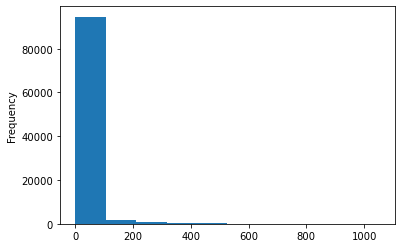

In [35]:
gap_date.plot.hist()

<AxesSubplot:ylabel='Frequency'>

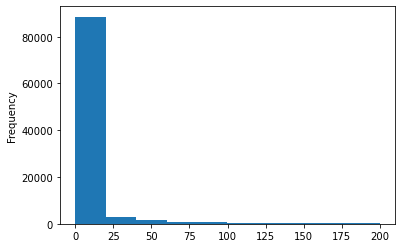

In [43]:
gap_date[gap_date < 200].plot.hist()

In [38]:
gap_date.quantile(0.95) # 95% наблюдений меньше этого числа (или у 95% юзеров перерыв был =< 59.76 дней)

59.760440972222156

In [42]:
gap_date.quantile(0.90) # 90% наблюдений меньше этого числа (или у 90% юзеров перерыв был =< 18.32 дней)

18.325995370370403

Возьмем в качестве перерыва, после которого юзер считается "отвалившемся с курса" **значение 30** (60 < 30 < 18)
> gap_date.quantile(0.925)

In [44]:
drop_out_threshold = 30 * 24 * 60 * 60 # 30 дней в секундах - перерыв, после которого юзер считается "отвалившемся с курса"

In [48]:
now = events_train.timestamp.max() # последний timestamp (время последнего наблюдения) на момент выгрузки 

## Соберем датафрейм с "фичами" (подготовленными признаками для решения задачи). 

    1. Разметим отвалился юзер или нет, при этом нужно исключить тех, кто уже прошел курс (получил 100 баллов)

In [75]:
user_data = events_train.groupby('user_id', as_index=False).agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [76]:
user_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [77]:
user_data['is_gone_user'] = (now - user_data.last_timestamp) > drop_out_threshold

In [78]:
user_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [79]:
submissions_score = submissions_train.pivot_table(index='user_id',
                                 columns='submission_status', # значения станут колонками
                                 values='step_id', # к этим значениям будем применять аггрегацию
                                 aggfunc='count', # функция агрегации
                                 fill_value=0).reset_index()

In [80]:
user_data = user_data.merge(submissions_score, how='outer', on='user_id') # how='outer' - иначе потеряются данные юзеров без попыток
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [81]:
user_data = user_data.fillna(value=0)
user_data.head(10)

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
5,8,1481466913,True,9.0,21.0
6,9,1484999497,True,0.0,0.0
7,11,1526140625,False,0.0,0.0
8,14,1436368676,True,0.0,1.0
9,16,1513162585,True,77.0,106.0


In [82]:
events_train_data = events_train.pivot_table(index='user_id',
                                 columns='action', # значения станут колонками
                                 values='step_id', # к этим значениям будем применять аггрегацию
                                 aggfunc='count', # функция агрегации
                                 fill_value=0).reset_index()
events_train_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [83]:
user_data = user_data.merge(events_train_data, how='outer', on='user_id') # how='outer' - иначе потеряются данные юзеров без попыток
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [97]:
# посчитаем кол-во дней проведенных пользователем на курсе
user_unique_days = events_train.groupby('user_id').day.nunique()
user_unique_days = user_unique_days.to_frame().reset_index()

In [100]:
user_data = user_data.merge(user_unique_days, how='outer', on='user_id').fillna(value=0)

In [101]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,user_unique_days,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,0.0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,1.0,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,2.0,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,7.0,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,0.0,1


In [103]:
user_data.user_id.nunique() == events_train.user_id.nunique() # проверка на то, не потерялись ли данные

True

In [104]:
user_data['passed_course'] = user_data.passed > 170
user_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,user_unique_days,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,0.0,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,1.0,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,2.0,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,7.0,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,0.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,1.0,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1.0,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,1.0,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,4.0,2,False


In [106]:
user_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,user_unique_days,day
passed_course,,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [107]:
1425 / 17809 *100 # 8% закончили курс

8.001572238755687